In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
%matplotlib inline
sns.set()
rcParams['figure.figsize']=(16,8)


# Подготовка исходных данных

In [2]:
train_path = 'train.csv'
test_path = 'test.csv'

In [3]:
df_train = pd.read_csv(train_path)
df_value= pd.read_csv(test_path)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


##  Обзор исходных данных

In [4]:
print(f'Число объектов "тренировочной" выборки  =>{df_train.shape[0]}')
print(f'Число признаков "тренировочной" выборки  =>{df_train.shape[1]}')

df_train.shape[1]-1==df_value.shape[1]

Число объектов "тренировочной" выборки  =>10000
Число признаков "тренировочной" выборки  =>20


True

В тренировочной выборке на одну колонку больше, чем в проверочной. <br>
Дополнительный столбец соответствует целевой пременной.

In [5]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Признаки Id (идентификационный номер квартиры) и DistrictId (идентификационный номер района) <br>
    числовые. Вместе с тем они не несут в никакой числовой информации. преобразуем их к str-типу

In [6]:
df_train['Id'] = df_train['Id'].astype('str')
df_train['DistrictId'] = df_train['DistrictId'].astype('str');

### Удаление пропусков
Для этого возьмем разность от результата действия функции len(находит общее число строк для каждого признака) <br>
и метода count (находит число ненулевых строк для каждого признака)

In [7]:
len(df_train) - df_train.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Все признаки, за исключением жилой площади и показателя местности, связанного со здоровьем, представлены полно.<br>
Для заполнения ндостающих значений жилой площади, найдем среднее от разности полной площади, и суммы жилой площади  <br>
и площади кухонь. Вычисления проводятся для ненулевых строк.

In [8]:
dif_square = (df_train.loc[df_train['LifeSquare'].notnull(), 'Square'] - \
              df_train.loc[df_train['LifeSquare'].notnull(), 'LifeSquare'] - \
              df_train.loc[df_train['LifeSquare'].notnull(), 'KitchenSquare'] ).mean()
              

In [9]:
df_train['LifeSquare'].mean()

37.19964482767308

Разница небольшая. Поэтому нулевые значения признака LifeSquare моожно заменять <br>
средним от разности соответсвующих строк  общей площади и площади кухонь.

In [10]:
df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = \
                                              (df_train.loc[df_train['LifeSquare'].isnull(), 'Square'] - \
                                               df_train.loc[df_train['LifeSquare'].isnull(), 'KitchenSquare']).mean()


Пропущенные значения Healthcare_1 заменим средними Ненулевыми значениями

In [11]:
df_train.loc[df_train['Healthcare_1'].isnull(), 'Healthcare_1'] = \
                                      (df_train.loc[df_train['Healthcare_1'].notnull(), 'Healthcare_1']).mean()

### Анализ целевой переменной
Построим гистограмму с 25 бинами.

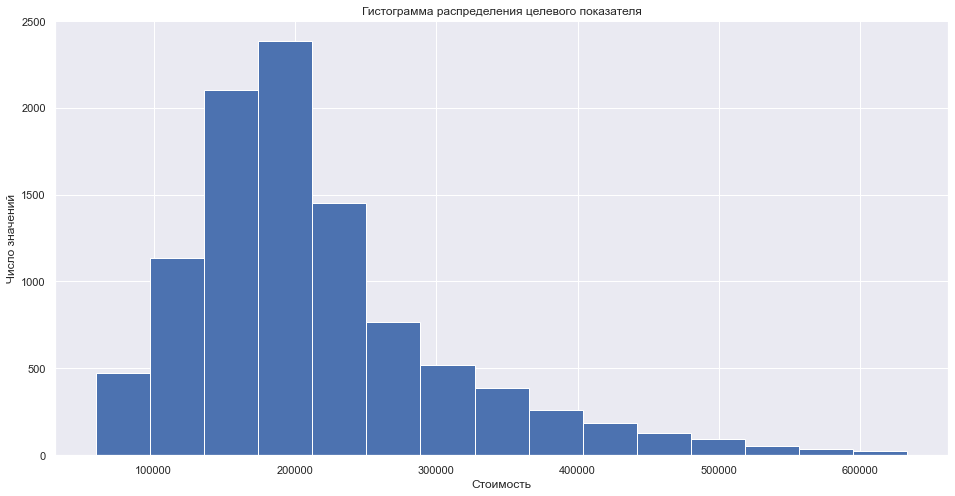

In [12]:
plt.hist(df_train['Price'], bins=15)
plt.xlabel('Стоимость')
plt.ylabel('Число значений')
plt.title('Гистограмма распределения целевого показателя');

Гистограмма несиметрична, поэтому в качестве оценки среднего будет браться медиана. <br>
Посмотрим на основные статистические показатели числовых признаков

## Числовые признаки

In [13]:
print(df_train.select_dtypes(include=['int64','float64']).columns.to_list())

['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price']


###  Обработка выбросов


In [14]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,41.799474,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,77.102655,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,736.734238,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,38.334514,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1142.904460,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,58.968832,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1142.904460,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


## Общая площадь (Square), жилая площадь (LifeSquare) и площадь кухонь (KitchenSquare)

In [15]:
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Значение ноль выглядит как пропущенное при заполнении значение. 10 и 19 скорее всего ошибочны. <br>
Поэтому заменим их на медианное значение.

In [16]:
df_train.loc[df_train['Rooms'].isin([0,10,19]),'Rooms']=df_train['Rooms'].median()

Удалим выбросы, оставив значения показателей площади, <br>
жилой площади и площади кухни в диапазоне между 1 и 3 квартилем

In [17]:
df_train = df_train[(df_train['KitchenSquare'] > df_train['KitchenSquare'].quantile(0.025)) & (df_train['KitchenSquare'] < df_train['KitchenSquare'].quantile(0.975))]
df_train = df_train[(df_train['Square'] > df_train['Square'].quantile(0.025)) & (df_train['Square'] < df_train['Square'].quantile(0.975))]
df_train = df_train[(df_train['LifeSquare'] > df_train['LifeSquare'].quantile(0.025)) & (df_train['LifeSquare'] < df_train['LifeSquare'].quantile(0.975))]

In [18]:
print(f'Число объектов сократилось до {df_train.shape[0]}')

Число объектов сократилось до 8163


## Число этажей в здании (HouseFloor) и этаж (Floor)

In [19]:
print(df_train['HouseFloor'].sort_values().unique())
print(df_train['Floor'].sort_values().unique())

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  29.  30.  32.  37.  40.  44.  45.  48.  99. 117.]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 31 32 33 42]


Видно, что в признаке HouseFloor присутствуют здания с 0 этажей. Заменим такие ошибочные значения на
медиану

In [20]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()

Этаж жилья не должен превышать число этажей в здании. Нет оснований приписывать этажу жилья какие либо определенные значения. <br> Поэтому заполним их случайными числами от 1 до этажности здания.

In [21]:
out_floor = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index

In [22]:
import random
df_train.loc[out_floor,'Floor'] = df_train.loc[out_floor,'HouseFloor'].apply(lambda x: random.randint(1,x))

## Год постройки здания (HouseYear)
Отсортируем и выведим на экран уникальные значения этого показателя

In [23]:
df_train['HouseYear'].sort_values(ascending = False).unique()[0:10]

array([20052011,     4968,     2020,     2019,     2018,     2017,
           2016,     2015,     2014,     2013], dtype=int64)

Присутствуют явно аномальнoe значениe. Год посройки здания не может превышать год сбора данных. Поэтому заменим такие значения на год сбора данных.

In [24]:
df_train.loc[df_train['HouseYear'] > 2022,'HouseYear'] = 2022

In [25]:
df_train['HouseYear'].sort_values(ascending = False).unique()[0:10]

array([2022, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012],
      dtype=int64)

## Категориальные признаки

In [26]:
df_train.select_dtypes(include = 'object').columns

Index(['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

Всего пять категориальных признаков

Экологические показатели представлены признаками  Ecology_2 и Ecology_3

In [27]:
print(f'Экологический показатель 2 \n{df_train["Ecology_2"].value_counts()} \n {"-"*20}')
print(f'Экологический показатель 3 \n{df_train["Ecology_3"].value_counts()}')

Экологический показатель 2 
B    8079
A      84
Name: Ecology_2, dtype: int64 
 --------------------
Экологический показатель 3 
B    7905
A     258
Name: Ecology_3, dtype: int64


Видно, что каждый из  экологических показателя принимают только  по два значения - А и B.

In [28]:
print(f'По отношению к близости магазина возможны также только два значения \n{df_train["Shops_2"].value_counts()}')

По отношению к близости магазина возможны также только два значения 
B    7609
A     554
Name: Shops_2, dtype: int64


Для удобство сделаем замену числовых значений А и B Их числовыми эквивалентами 1 и 0.

In [29]:
df_train['Ecology_2'].replace({'A':0, 'B':1},inplace=True)
df_train['Ecology_3'].replace({'A':0, 'B':1},inplace=True)
df_train['Shops_2'].replace({'A':0, 'B':1},inplace=True)

 Рассмотрим иденификаторы районов

In [30]:
print(f"Всего {len(df_train['DistrictId'].value_counts())} идентификторов района")


Всего 204 идентификторов района


In [31]:
print('Из них наибольшее колличество жилья находится в следующих пяти районах')
df_train['DistrictId'].value_counts().head(5)

Из них наибольшее колличество жилья находится в следующих пяти районах


27    554
1     504
23    391
6     338
9     261
Name: DistrictId, dtype: int64

В зависимости от района и числа квартир определим медианную стоимость. 

In [32]:
median_price_by_distr = df_train.groupby(['DistrictId','Rooms'],  as_index=False).agg({'Price': 'median'}).rename(columns={'Price':'Median_price_by_distr'});

Добавим новый признак, содержащий медианную оценку стоимости в зависимости от числа кватир и района. <br> для этого
сгруппируем таблицу признаком median_price_by_distr 

In [33]:
df_train = df_train.merge(median_price_by_distr, on = ['DistrictId','Rooms'], how = 'left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Median_price_by_distr
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,1,33,7976,5,1142.90446,0,11,1,184966.930730,203384.328026
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,46,10309,1,240.00000,1,16,1,300009.450063,297041.145784
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1,23,5735,3,1084.00000,0,5,1,175616.227217,169246.115943
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,35,5776,1,2078.00000,2,4,1,150226.531644,158791.017955
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,1,35,7715,4,990.00000,0,6,1,215898.447742,303152.615007


На этом создание новых признаков обучающей выборки заканчивается. Произведем отбор признаков. Выведем полный список (первоначальные + созданные) и затем отберем признаки, имеющие значения для обучения модели.

In [34]:
print(df_train.columns.to_list())

['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'Median_price_by_distr']


In [35]:
feature_names=['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Median_price_by_distr']
target_name='Price' # целевая перемаенная

In [36]:
X = df_train[feature_names]
y=df_train[target_name]

## Подготовка  тестовой выборки

In [37]:
print(df_value.columns.to_list())

['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']


В тестовой выборке количество признаков отличается от количества признаков в обучающей выборке. Из дополнительных данных Обучающей таблицы таблицы интерес представляет только медианная оценка стоимости, которую и добавим.
Также сделаем замену значений категориальные признаков

### Преобразование категориальных признаков

In [38]:
df_value['Ecology_2'].replace({'A':0, 'B':1},inplace=True)
df_value['Ecology_3'].replace({'A':0, 'B':1},inplace=True)
df_value['Shops_2'].replace({'A':0, 'B':1},inplace=True)

## Преобразование типов

In [39]:
df_value['Id'] = df_value['Id'].astype('str')
df_value['DistrictId'] = df_value['DistrictId'].astype('str');

## Удаление пропусков

In [40]:
df_value.loc[df_value['LifeSquare'].isnull(), 'LifeSquare'] = \
                                              (df_value.loc[df_value['LifeSquare'].isnull(), 'Square'] - \
                                               df_value.loc[df_value['LifeSquare'].isnull(), 'KitchenSquare']).mean()
df_value.loc[df_value['Healthcare_1'].isnull(), 'Healthcare_1'] = \
                                      (df_value.loc[df_value['Healthcare_1'].notnull(), 'Healthcare_1']).mean()
id_test = df_value['Id']

### Добавим медианную оценку стоимости в тестовую таблицу и сформируем окончательный вид таблицы

In [41]:
df_value = df_value.merge(median_price_by_distr, on = ['DistrictId','Rooms'], how = 'left')
#df_value[df_value['Median_price_by_distr'].isnull()]=df_value[df_value['Median_price_by_distr'].notnull()].mean()
df_value.fillna(method='backfill', inplace = True)
X_test = df_value[feature_names]

Таблица с валидационными данными готова

## Создание таблиц с обучающими и валидационными признаками

In [42]:
from sklearn.model_selection import train_test_split

Разбиение данных на тренировочную и тестовую выборку можно выполнить с помощью функции train_test_split из модуля sklearn.model_selection

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,shuffle=True, random_state=30)

Для обучения и предсказания используем модель ансамбль деревьев решений. Для каждого обучаемого дерева решений создаётся подвыборка из исходной тренировочной выборки. "Побеждает" решение, за которое "проголосовало" наибольшее число деревьев.

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2 # метрика качества

Создаем модель и обучим ее на тренировочной выборке и Проведем валидацию модели.

In [45]:
rf_model = RandomForestRegressor( random_state  = 10) 
rf_model.fit(X_train,y_train)

RandomForestRegressor(random_state=10)

Выполним предсказание для тестовой и обучающей выборки

In [46]:
y_pred_train = rf_model.predict(X_train)
y_pred_val = rf_model.predict(X_val)

Для оценки качества модели создадим функцию. Оценка качества производится по метрике R2 - коэффициент детерминации.

In [47]:
def evaluate_preds(true_values, pred_values, save=False):
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3))          )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.962


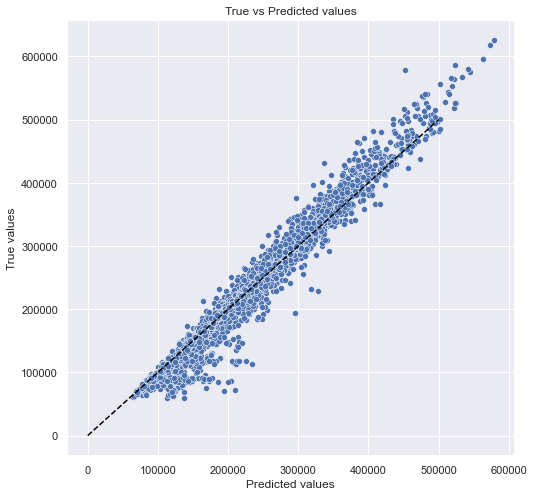

In [48]:
evaluate_preds(y_train, y_pred_train)

На обучающей выборке модель показала хороший результат.  Наблюдается высокая корреляция между предсказанными и истинными данными

R2:	0.707


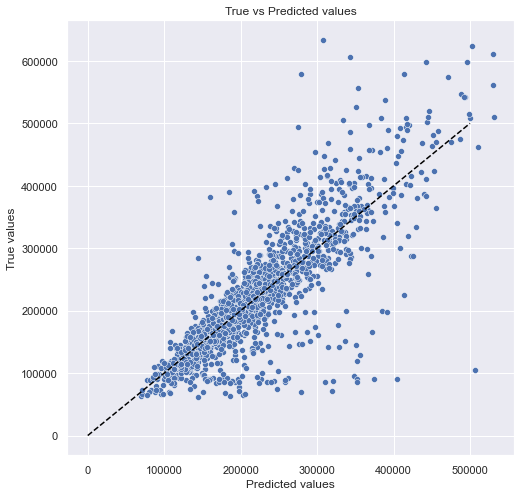

In [49]:
evaluate_preds(y_val, y_pred_val)

На валидационной выборке модель показала удовлетворительный результат. Точность по метрике R2 превышает 0.6
Осуществим прогноз для загруженных тестовых данных

In [50]:
y_pred_test = rf_model.predict(X_test)

In [51]:
pred_data_fr = pd.DataFrame(y_pred_test, columns=['Price',], index=id_test )


Сохраним прогноз в CSV файл

In [52]:
pred_data_fr.to_csv('my_pred_for_price.csv')